### Install required libraries

In [112]:
!pip install pydicom
!pip install opencv-python
!pip install imgaug
!pip install h5py==2.10.0
!pip install keras==2.1.6
!pip install pandas
!pip install seaborn
!pip install sklearn

In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

### Import required libraries

In [4]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
import seaborn as sn
import pandas as pd
import time
import warnings 
warnings.filterwarnings("ignore")
IMAGE_SIZE = 1024

In [5]:
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


### Set directories for data and weights

In [72]:
ROOT_DIR = '/home/ubuntu/data'
DICOM_DIR = os.path.join(ROOT_DIR, 'stage_2_train_images')
TEST_DICOM_DIR = os.path.join(ROOT_DIR, 'stage_2_test_images')
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
MODEL_OUTPUT_PATH = os.path.join(ROOT_DIR, 'model_output.csv')
DATA_LABELS_PATH = os.path.join(ROOT_DIR, 'stage_2_train_labels.csv')

In [7]:
def get_model_directory():
    log_dir = 'logs' + time.strftime('%Y-%m-%d %H-%M-%S')
    model_directory = os.path.join(ROOT_DIR, log_dir)
    print(model_directory)
    return model_directory

In [8]:
def get_dicom_fps(dicom_dir):    
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

In [9]:
def create_image_annotaions():
    lables = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
    image_files = glob.glob(DICOM_DIR+'/'+'*.dcm')
    image_annotations = {fp: [] for fp in image_files}
    for index, row in lables.iterrows():
        fp = os.path.join(DICOM_DIR, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    
    return (image_files, image_annotations)

(image_files, image_annotations) = create_image_annotaions()

DETECTOR CONFIG

In [10]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
        
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 100
    
#     def __init__(self, STEPS_PER_EPOCH=100, LEARNING_RATE=0.001, IMAGES_PER_GPU=8):
#         Config.__init__(self) 
#         self.STEPS_PER_EPOCH = STEPS_PER_EPOCH
#         self.LEARNING_RATE = LEARNING_RATE
#         self.IMAGES_PER_GPU = IMAGES_PER_GPU

In [11]:
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [12]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

DETECTOR DATASET

In [13]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [14]:
def split_train_val_data(sample_size):
    sorted(image_files)
    random.seed(10)
    random.shuffle(image_files)
    #image_fps_sample = image_files
    image_fps_sample = list(image_files[:sample_size])
    random.shuffle(image_fps_sample)
    train_image_count = int(0.8 * len(image_fps_sample))
    train_image_files = image_fps_sample[:train_image_count]
    val_image_files = image_fps_sample[train_image_count:]
    return (train_image_files, val_image_files)

In [15]:
def prepare_data(train_image_files, val_image_files):
    dataset_train = DetectorDataset(train_image_files, image_annotations, IMAGE_SIZE, IMAGE_SIZE)
    dataset_train.prepare()
    dataset_val = DetectorDataset(val_image_files, image_annotations, IMAGE_SIZE, IMAGE_SIZE)
    dataset_val.prepare()
    print(f"Train size: {len(train_image_files)}, Validation size: {len(val_image_files)}")
    return (dataset_train, dataset_val)

In [16]:
def train_model(model, training_data, validation_data, learning_rate, epochs, augmentation=None):
    model.keras_model.metrics
    model.train(training_data, validation_data, 
                learning_rate=learning_rate, 
                epochs=epochs, 
                layers='all',
               augmentation=augmentation)

In [17]:
def create_model(mode, config, model_dir, weights, exclude = None):
    model = modellib.MaskRCNN(mode=mode, 
                              config=config,
                              model_dir=model_dir)
    if(exclude == None):
        model.load_weights(weights, by_name = True)
    else:
        model.load_weights(weights, by_name = True, exclude = exclude)
    
    return model

### Create Model in training mode with pre-existing weights

In [18]:
MODEL_DIR = get_model_directory()

/home/ubuntu/data/logs2021-01-03 11-11-24


In [17]:
model = create_model(mode='training', config=config, 
                     model_dir=MODEL_DIR, 
                     weights= COCO_WEIGHTS_PATH,
                     exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
#hack to prevent an error
model.keras_model.metrics = []






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead






In [18]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Data preperation for model

In [33]:
(train_image_files, val_image_files) = split_train_val_data(sample_size=20000)

In [34]:
(dataset_train, dataset_val) = prepare_data(train_image_files, val_image_files)

Train size: 16000, Validation size: 4000


#### > Create augmentation data

In [21]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

### Training Model

In [22]:
NUM_EPOCHS = 5
train_model(model, dataset_train, dataset_val, config.LEARNING_RATE, NUM_EPOCHS, augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/data/logs2020-12-26 10-44-29/pneumonia20201226T1044/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

### Create Model in infernce mode with trained weights

In [21]:
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [22]:
# select trained model 
def get_latest_weights(model, config):
    dir_names = next(os.walk(model.model_dir))[1]
    key = config.NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)

    if not dir_names:
        import errno
        raise FileNotFoundError(
            errno.ENOENT,
            "Could not find model directory under {}".format(self.model_dir))

    fps = []
    # Pick last directory
    for d in dir_names: 
        dir_name = os.path.join(model.model_dir, d)
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            print('No weight files in {}'.format(dir_name))
        else:
            checkpoint = os.path.join(dir_name, checkpoints[-1])
            fps.append(checkpoint)

    model_path = sorted(fps)[-1]
    print('Found model {}'.format(model_path))
    return model_path

In [24]:
#model_path = get_latest_weights(model, config)

In [25]:
model_path = '/home/ubuntu/data/final_weights/mask_rcnn_pneumonia_0014.h5'

In [35]:
# Recreate the model in inference mode
model = create_model(mode='inference', config=inference_config, 
                     model_dir=MODEL_DIR, 
                     weights= model_path)


In [113]:
def evaluate_model(model, dataset_val, config):
    fp = 0
    tp = 0
    fn = 0
    tn = 0
    correct = 0
    actuals = []
    predictions = []
    for image_id in dataset_val.image_ids:
        image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
        result = model.detect([image])[0]
        orig_class = 0 if len(class_ids) == 0 else 1
        predicted_class = 0 if len(result['rois']) == 0 or max(result['scores']) < class_score_threshold else 1
        if orig_class == predicted_class:
            correct = correct + 1
        if orig_class == 0 and predicted_class == 1:
            fp = fp + 1
        if orig_class == 0 and predicted_class == 0:
            tn = tn + 1
        if orig_class == 1 and predicted_class == 0:
            fn = fn + 1
        if orig_class == 1 and predicted_class == 1:
            tp = tp + 1
            
        predictions.append(predicted_class)
        actuals.append(orig_class)
        
    return (actuals,predictions,tp,fp,tn,fn)

In [114]:
#from mrcnn.utils import compute_ap
class_score_threshold = 0.98
def classification_report(tp,fp,tn,fn):
    accuracy = ((tp+tn)/(tp+fp+tn+fn))*100
    tpr = tp/(tp+fn)
    fnr = fn/(fn+tp)
    fpr = fp/(fp+tn)
    tnr = tn/(tn+fp)
    precision = tp/(tp+fp)
    f1_score = (2*precision*tpr)/(precision+tpr)
    return (accuracy,tpr,fnr,fpr,tnr,precision,f1_score)

In [115]:
def plot_roc_curve(fprs, tprs, area_under_curve):
    plt.plot(fprs, tprs, color='green', label='ROC curve (area = %0.2f)' % area_under_curve)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel('False Positiv Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [67]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset_val, config, 10, use_mini_mask=False)
#image

In [70]:
image_path = dataset_val.source_image_link(10)
image_path

'/home/ubuntu/data/stage_2_train_images/f10b2c7a-ceb3-4370-8761-6f3da9d08746.dcm'

### Calculat evaluation metrics

In [116]:
(actuals,predictions,tp,fp,tn,fn) = evaluate_model(model=model, dataset_val=dataset_val, config=inference_config)
(accuracy,tpr,fnr,fpr,tnr,precision,f1_score) = classification_report(tp,fp,tn,fn)

In [117]:
(accuracy,tpr,fnr,fpr,tnr,precision,f1_score,tp,fp,tn,fn)

(79.10000000000001,
 0.3468208092485549,
 0.653179190751445,
 0.08644338118022328,
 0.9135566188197767,
 0.5253940455341506,
 0.41782729805013924,
 300,
 271,
 2864,
 565)

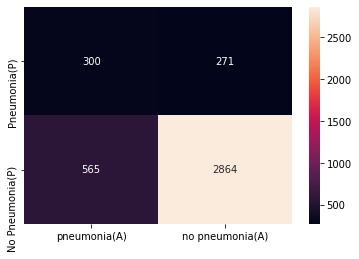

In [118]:
array = [[tp, fp],
         [fn, tn]]

df = pd.DataFrame(array, ['Pneumonia(P)', 'No Pneumonia(P)'], ['pneumonia(A)', 'no pneumonia(A)'])
sn.heatmap(df, annot=True, fmt ='d')

plt.show()

In [106]:
from sklearn.metrics import roc_curve, roc_auc_score

In [119]:
fprs, tprs, thresholds = roc_curve(actuals, predictions) 
area_under_curve = roc_auc_score(actuals, predictions)
print(f'Area Under Curve: {area_under_curve}')

Area Under Curve: 0.6301887140341658


In [120]:
print(f'Accuracy : {round(accuracy, 2)}%',end='\n\n')

print(f'True Positive Rate (Recall): {round(tpr, 2)}')
print(f'Positive Predictive value  (Precision): {round(precision, 2)}')
print(f'False Negative Rate (Miss Rate) : {round(fnr, 2)}')
print(f'F1 Score: {round(f1_score, 2)}',end='\n\n')

print(f'True Negative Rate: {round(tnr, 2)}')
print(f'False Positive Rate : {round(fpr, 2)}')

Accuracy : 79.1%

True Positive Rate (Recall): 0.35
Positive Predictive value  (Precision): 0.53
False Negative Rate (Miss Rate) : 0.65
F1 Score: 0.42

True Negative Rate: 0.91
False Positve Rate : 0.09


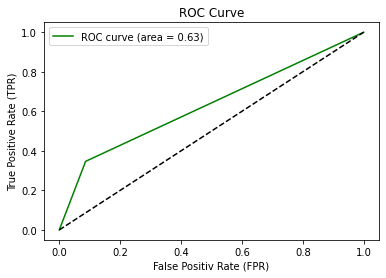

In [121]:
plot_roc_curve(fprs,tprs, area_under_curve)

In [126]:
def save_model_data(model_data):
    if os.path.exists(MODEL_OUTPUT_PATH) == false:
        with open(MODEL_OUTPUT_PATH, 'a') as file:
            file.write("Training Size,Batch Size,Learning Rate,Epochs,Accuracy,TPR,FNR,FPR,TNR,Precision,F1 Score,TP,FP,FN,TN,Weights Path\n")
            #data_write = "5000,8,0.001,5,70.40,0.53,0.46,0.25,0.75,0.20,0.41,116,196,100,588,nil"
        
    with open(MODEL_OUTPUT_PATH, 'a') as file:
        data_write = model_data+'\n'
        file.write(data_write)

In [190]:
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [214]:
def optimize_model(config, sample_size, NUM_EPOCHS, augmentation, inference_config):

    MODEL_DIR = get_model_directory()
    model = create_model(mode='training', config=config, 
                         model_dir=MODEL_DIR, 
                         weights= COCO_WEIGHTS_PATH,
                         exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
    #hack to prevent an error
    model.keras_model.metrics = []
    (train_image_files, val_image_files) = split_train_val_data(sample_size=sample_size)
    (dataset_train, dataset_val) = prepare_data(train_image_files, val_image_files)

    #NUM_EPOCHS = 5
    train_model(model, dataset_train, dataset_val, config.LEARNING_RATE, NUM_EPOCHS, augmentation)
    model_path = get_latest_weights(model, config)
    
    # Recreate the model in inference mode
    inference_model = create_model(mode='inference', config=inference_config, 
                         model_dir=MODEL_DIR, 
                         weights= model_path)
    (actuals,predictions,tp,fp,tn,fn) = evaluate_model(model=model, dataset_val=dataset_val, config=inference_config)
    (accuracy,tpr,fnr,fpr,tnr,precision,f1_score) = classification_report(tp,fp,tn,fn)
    
    model_out = ""
    model_out +=sample_size+","
    model_out +=config.IMAGES_PER_GPU+","
    model_out +=config.LEARNING_RATE+","
    model_out +=NUM_EPOCHS+","
    model_out +=accuracy+","
    model_out +=tpr+","
    model_out +=fnr+","
    model_out +=fpr+","
    model_out +=tnr+","
    model_out +=precision+","
    model_out +=f1_score+","
    model_out +=tp+","
    model_out +=fp+","
    model_out +=fn+","
    model_out +=tn+","
    model_out +=model_path
    print(model_out)
    save_model_data(model_out)

#### Training model for different hyper parameters

In [45]:
#optimize_model(config=config, sample_size=5000, NUM_EPOCHS=10, augmentation=augmentation, inference_config=inference_config)
#optimize_model(config=config, sample_size=5000, NUM_EPOCHS=20, augmentation=augmentation, inference_config=inference_config)
#optimize_model(config=config, sample_size=5000, NUM_EPOCHS=25, augmentation=augmentation, inference_config=inference_config)
#optimize_model(config=config, sample_size=10000, NUM_EPOCHS=10, augmentation=augmentation, inference_config=inference_config)

In [127]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [54]:
dataset_val.class_names

['BG', 'Lung Opacity']


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



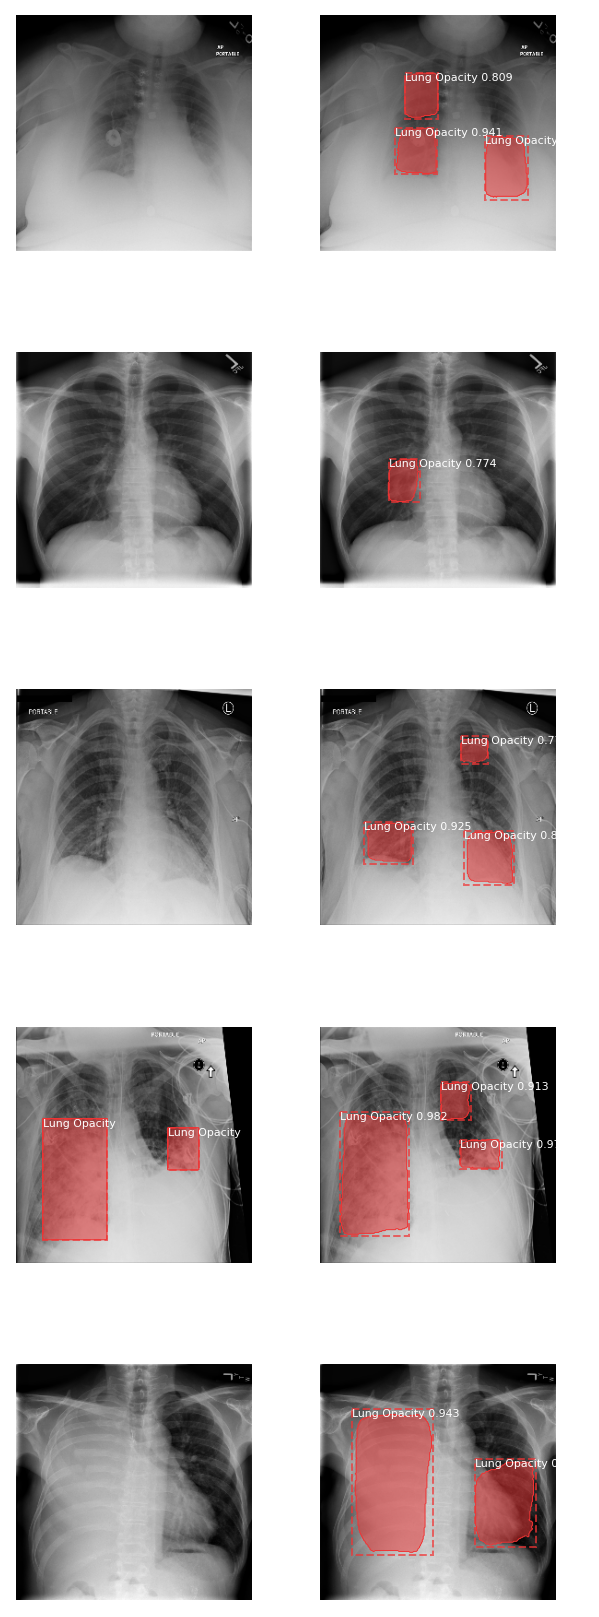

In [55]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(5):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    plt.subplot(5, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(5, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

### Create submission csv for test images

In [58]:
test_image_files = get_dicom_fps(TEST_DICOM_DIR)

In [59]:
def predict(image_files, filepath='submission.csv', min_conf=class_score_threshold):
    # assume square image
    resize_factor = IMAGE_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_files):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] >= min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        bboxes_str += ' | '
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [60]:
image_id = glob.glob(TEST_DICOM_DIR+'/'+'1fbb1bca-4e41-4758-8ed8-cc4cbde7dffe.dcm')[0]
image_id

'/home/ubuntu/data/stage_2_test_images/1fbb1bca-4e41-4758-8ed8-cc4cbde7dffe.dcm'

In [63]:
submission_csv = 'submission' + time.strftime('%Y-%m-%d %H-%M-%S')+'.csv'
print(submission_csv)
submission_fp = os.path.join(ROOT_DIR, submission_csv)
predict(test_image_files, filepath=submission_fp)
print(submission_fp)

  0%|          | 1/3000 [00:00<05:58,  8.36it/s]

submission2021-01-03 12-16-57.csv


100%|██████████| 3000/3000 [05:05<00:00,  9.83it/s]

/home/ubuntu/data/submission2021-01-03 12-16-57.csv


In [64]:
output = pd.read_csv(submission_fp, names=['patientId', 'PredictionString'])
output.head()

,patientId,PredictionString
0,patientId,PredictionString
1,2a89b8bf-72ac-4f52-8e8e-ddb451b33a3e,0.98 188.0 388.0 240.0 184.0 | 0.98 616.0 42...
2,218b656e-0c88-493c-a567-af93166ec37a,0.98 420.0 508.0 120.0 144.0 |
3,1225df58-5bdb-4dfb-bf61-9eeae31ac7c0,NaN
4,11463b21-b97a-4b0b-97e1-13ab4033dd22,0.99 316.0 600.0 164.0 124.0 |
